In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('./data/train_data.csv')


## Encodage des Variables

In [46]:
continuous_features = ["CreditScore", "Age", "Balance", "EstimatedSalary"]
categorical_features = ["Geography", "Gender", "HasCrCard", "IsActiveMember"]

# encoder = OneHotEncoder(sparse_output=False, drop='first')  

# encoded_data = encoder.fit_transform(df[["Gender", "Geography"]])
# encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(["Gender", "Geography"]))

# df = df.drop(columns=["Gender", "Geography"]).reset_index(drop=True)
# df = pd.concat([df, encoded_df], axis=1)

# df.head()  


for col in categorical_features:
    df[col] = df[col].astype("category")



## Feature Engineering

In [47]:
df["BalanceMinusSalary"] = df["Balance"] - df["EstimatedSalary"]
df["CreditScorePerBalance"] = df["CreditScore"] / (df["Balance"] +1)
# df["BalancePerTenure"] = df["Balance"] / (df["Tenure"] +1)
df["BalancePerSalary"] = df["Balance"] / (df["EstimatedSalary"] +1)
# df["BalanceToProdcutsRatio"] = df["Balance"] / (df["NumOfProducts"] +1)
# df["TenureToAge"] = df["Tenure"] / (df["Age"] +1)


## Feature Selection

In [48]:
df.drop(columns=["CustomerId", "Surname", "ID", "HasCrCard"], inplace=True)

## Normalisation

In [49]:
# numeric_cols = ["Age", "Balance", "CreditScorePerBalance", "CreditScorePerBalancePerTenure", "BalancePerTenure", "BalanceMinusSalary"]
# scaler = StandardScaler()
# df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# print(df.head())

In [50]:
# Define Features & Target
X = df.drop(columns=["Exited"])
y = df["Exited"]

# lgb_model = lgb.LGBMClassifier(verbose=-1)

# lgb_model.fit(X, y)

# # Get feature importance
# lgb_importance = lgb_model.feature_importances_

# # Create a DataFrame for plotting
# feature_importance_df = pd.DataFrame({
#     "Feature": X.columns,
#     "LightGBM Importance": lgb_importance
# })

# # Sort by importance
# feature_importance_df = feature_importance_df.set_index("Feature")
# feature_importance_df = feature_importance_df.sort_values(by="LightGBM Importance", ascending=False)

# # Plot the feature importance
# plt.figure(figsize=(12, 6))
# # sns.barplot(data=feature_importance_df, x=feature_importance_df.index, y="XGBoost Importance", color="blue", label="XGBoost")
# sns.barplot(data=feature_importance_df, x=feature_importance_df.index, y="LightGBM Importance", color="red", alpha=0.6, label="LightGBM")

# plt.xticks(rotation=90)
# plt.title("Feature Importance for XGBoost & LightGBM")
# plt.xlabel("Features")
# plt.ylabel("Importance Score")
# plt.legend()
# plt.show()

In [51]:
# import logging
# import lightgbm as lgb
# import optuna
# import numpy as np
# from sklearn.metrics import f1_score
# from sklearn.model_selection import StratifiedKFold

# # Configuration du logger
# logging.basicConfig(
#     filename="optuna_lightgbm.log",
#     level=logging.INFO,
#     format="%(asctime)s - %(levelname)s - %(message)s",
#     datefmt="%Y-%m-%d %H:%M:%S"
# )

# def log(message):
#     """ Fonction pour écrire les logs dans le fichier et afficher en console (optionnel). """
#     logging.info(message)
#     # print(message)  # Commente cette ligne si tu veux éviter d'afficher dans la console.

# Trouver le meilleur seuil pour maximiser F1 Score
# def find_best_threshold(y_true, y_probs):
#     thresholds = np.linspace(0.1, 0.9, 50)  # Tester 50 valeurs entre 0.1 et 0.9
#     best_threshold = 0.5
#     best_f1 = 0

#     for threshold in thresholds:
#         y_pred = (y_probs >= threshold).astype(int)
#         f1 = f1_score(y_true, y_pred)
#         if f1 > best_f1:
#             best_f1 = f1
#             best_threshold = threshold

#     return best_threshold, best_f1

# # Optuna objective function
# def objective(trial):
#     params = {
#         "objective": "binary",
#         "metric": "binary_logloss",
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
#         "boosting_type": "gbdt",
#         "n_estimators": trial.suggest_int("n_estimators", 70, 1000),
#         "num_leaves": trial.suggest_int("num_leaves", 50, 250),
#         "subsample": trial.suggest_float("subsample", 0.5, 1),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1),
#         "random_state": 42,
#         "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.5, 5.0),
#     }

#     skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#     f1_scores = []
#     thresholds = []

#     log(f"\n🔍 Evaluating Trial {trial.number + 1} with Parameters: {params}")

#     for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
#         X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

#         model = lgb.LGBMClassifier(**params)
#         model.fit(X_train, y_train)

#         # Obtenir les probabilités
#         y_probs = model.predict_proba(X_val)[:, 1]  # Probabilité de la classe 1

#         # Trouver le meilleur seuil pour maximiser F1
#         best_threshold, best_f1 = find_best_threshold(y_val, y_probs)

#         f1_scores.append(best_f1)
#         thresholds.append(best_threshold)

#         log(f"📊 Fold {fold} - Best Threshold: {best_threshold:.2f} - F1 Score: {best_f1:.4f}")

#     avg_f1 = np.mean(f1_scores)
#     avg_threshold = np.mean(thresholds)

#     log(f"✅ Trial {trial.number + 1} - Average F1 Score: {avg_f1:.4f} - Average Threshold: {avg_threshold:.2f}\n")

#     return avg_f1

# # Run Optuna study
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=500)

# # Print best parameters
# log("\n🎯 Best Hyperparameters for LightGBM:")
# log(str(study.best_params))
# log(f"💯 Best F1 Score: {study.best_value:.4f}")


In [52]:
# from sklearn.model_selection import train_test_split

# # Séparation du dataset en Train (80%) et Test (20%)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# print(f"✅ Taille du Train Set: {X_train.shape[0]} échantillons")
# print(f"✅ Taille du Test Set: {X_test.shape[0]} échantillons")

# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# # Meilleurs hyperparamètres trouvés par Optuna
# best_params = {
#     "objective": "binary",
#     "metric": "binary_logloss",
#     "learning_rate": 0.01128001103820329,
#     "boosting_type": "gbdt",
#     "n_estimators": 959,
#     "num_leaves": 82,
#     "subsample": 0.9898192764991187,
#     "colsample_bytree": 0.7150851486932676,
#     "random_state": 42,
#     "scale_pos_weight": 3.3682519378001508
# }

# # Entraîner le modèle final sur X_train
# final_model = lgb.LGBMClassifier(**best_params)
# final_model.fit(X_train, y_train)

# # Obtenir les probabilités sur X_test
# y_probs_test = final_model.predict_proba(X_test)[:, 1]

# # Trouver le meilleur seuil sur le TRAIN SET uniquement
# best_threshold, _ = find_best_threshold(y_train, final_model.predict_proba(X_train)[:, 1])

# # Transformer les probabilités en classes sur X_test avec ce seuil
# y_pred_test = (y_probs_test >= best_threshold).astype(int)

# print(f"✅ Meilleur Seuil de Décision: {best_threshold:.2f}")



In [53]:
# Matrice de confusion
# conf_matrix = confusion_matrix(y_test, y_pred_test)

# Affichage avec seaborn
# plt.figure(figsize=(6,4))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
# plt.xlabel("Prédictions")
# plt.ylabel("Réel")
# plt.title("Matrice de Confusion sur Test Set")
# plt.show()


In [54]:
# # Calcul des métriques principales
# accuracy = accuracy_score(y_test, y_pred_test)
# precision = precision_score(y_test, y_pred_test)
# recall = recall_score(y_test, y_pred_test)
# f1 = f1_score(y_test, y_pred_test)

# print(f"✅ Accuracy sur Test: {accuracy:.4f}")
# print(f"🎯 Precision sur Test: {precision:.4f}")
# print(f"⚡ Recall sur Test: {recall:.4f}")
# print(f"💯 F1 Score sur Test: {f1:.4f}")

# # Rapport détaillé
# print("\n📊 Classification Report sur Test Set:")
# print(classification_report(y_test, y_pred_test))


In [55]:
# plt.figure(figsize=(8,5))
# sns.histplot(y_probs_test, bins=50, kde=True, color="blue")
# plt.axvline(best_threshold, color="red", linestyle="dashed", label=f"Best Threshold = {best_threshold:.2f}")
# plt.xlabel("Probabilité de la Classe 1")
# plt.ylabel("Fréquence")
# plt.title("Distribution des Probabilités sur Test Set")
# plt.legend()
# plt.show()


✅ Meilleur Seuil Trouvé: 0.62 (F1 Score: 0.6952)
✅ Submission file 'submission.csv' saved successfully!


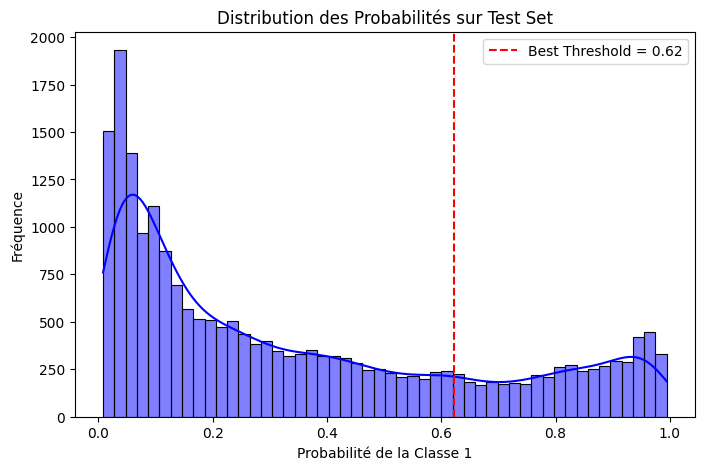

In [56]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

# Charger le dataset test
df_test = pd.read_csv('./data/test_data.csv')

# Convertir les features catégoriques
for col in categorical_features:
    df_test[col] = df_test[col].astype("category")

# Feature Engineering
df_test["BalanceMinusSalary"] = df_test["Balance"] - df_test["EstimatedSalary"]
df_test["CreditScorePerBalance"] = df_test["CreditScore"] / (df_test["Balance"] +1)
df_test["BalancePerSalary"] = df_test["Balance"] / (df_test["EstimatedSalary"] +1)

# Sauvegarder l'ID pour la soumission
df_ID_copy = df_test["ID"].copy()

# Nettoyage des colonnes inutiles
df_test.drop(columns=["CustomerId", "Surname", "ID", "HasCrCard"], inplace=True)

# Vérifier les colonnes manquantes ou en trop
missing_cols = set(X.columns) - set(df_test.columns)
if missing_cols:
    print(f"⚠️ Missing Columns in Test Set: {missing_cols}")
extra_cols = set(df_test.columns) - set(X.columns)
if extra_cols:
    print(f"⚠️ Extra Columns in Test Set: {extra_cols}")

# Meilleurs hyperparamètres trouvés par Optuna
best_params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 0.01128001103820329,
    "boosting_type": "gbdt",
    "n_estimators": 959,
    "num_leaves": 82,
    "subsample": 0.9898192764991187,
    "colsample_bytree": 0.7150851486932676,
    "random_state": 42,
    "scale_pos_weight": 3.3682519378001508
}

# Entraîner le modèle sur toutes les données
model = lgb.LGBMClassifier(**best_params)
model.fit(X, y)

# Obtenir les probabilités sur l'ensemble d'entraînement pour trouver le meilleur seuil
y_probs_train = model.predict_proba(X)[:, 1]  # Probabilités de la classe 1

# Trouver le meilleur seuil pour maximiser le F1 Score
def find_best_threshold(y_true, y_probs):
    thresholds = np.linspace(0.1, 0.9, 50)  # Tester 50 seuils entre 0.1 et 0.9
    best_threshold = 0.5
    best_f1 = 0

    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1

# Trouver le seuil optimal
best_threshold, best_f1 = find_best_threshold(y, y_probs_train)
print(f"✅ Meilleur Seuil Trouvé: {best_threshold:.2f} (F1 Score: {best_f1:.4f})")

# Appliquer ce seuil aux prédictions sur le test set
y_probs_test = model.predict_proba(df_test)[:, 1]
y_test_pred = (y_probs_test >= best_threshold).astype(int)

# Générer la soumission
submission = pd.DataFrame({"ID": df_ID_copy, "Exited": y_test_pred})
submission.to_csv("submission.csv", index=False)

print("✅ Submission file 'submission.csv' saved successfully!")

# Affichage de la distribution des probabilités
plt.figure(figsize=(8,5))
sns.histplot(y_probs_test, bins=50, kde=True, color="blue")
plt.axvline(best_threshold, color="red", linestyle="dashed", label=f"Best Threshold = {best_threshold:.2f}")
plt.xlabel("Probabilité de la Classe 1")
plt.ylabel("Fréquence")
plt.title("Distribution des Probabilités sur Test Set")
plt.legend()
plt.show()
